In [10]:
from pathlib import Path
import pandas as pd
from datetime import datetime, timedelta
from haversine import haversine, Unit   # pip install haversine
import numpy as np

ROOT = Path(r"E:/THINKLab/reviewedpaper/Geolife/Data")   # 原始 .plt 目录根
CACHE = Path(r"E:/THINKLab/reviewedpaper/Geolife/feather_cache")
CACHE.mkdir(exist_ok=True)

def load_plt(plt_path: Path, uid: str) -> pd.DataFrame:
    """读单个 .plt → DataFrame，并附加 user_id 列"""
    df = pd.read_csv(
        plt_path,
        skiprows=6,                      # Geolife 前 6 行是文件头
        names=["lat","lon","zeros","alt","days1980","date","time"]
    )
    df["user_id"] = uid
    df["dt"] = pd.to_datetime(df["date"] + " " + df["time"])
    return df[["user_id","dt","lat","lon","alt"]]

def build_cache():
    """一次性遍历全部 .plt 并落盘 feather，后续加载更快"""
    for p in ROOT.glob("*/*/*.plt"):
        uid = p.parts[-3]               # <user_id>/Trajectory/<file>.plt
        feather = CACHE / f"{uid}_{p.stem}.feather"
        if not feather.exists():
            load_plt(p, uid).to_feather(feather)

# 首次运行需要解注释：
build_cache()

C:\Users\Nick_James\AppData\Local\Temp\ipykernel_13248\1208737352.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["dt"] = pd.to_datetime(df["date"] + " " + df["time"])


In [11]:
df_all = pd.concat(pd.read_feather(f) for f in CACHE.glob("*.feather"))

count    1879.000000
mean        5.931879
std         6.237630
min         1.000000
25%         2.000000
50%         3.000000
75%         8.000000
max        29.000000
Name: devices, dtype: float64


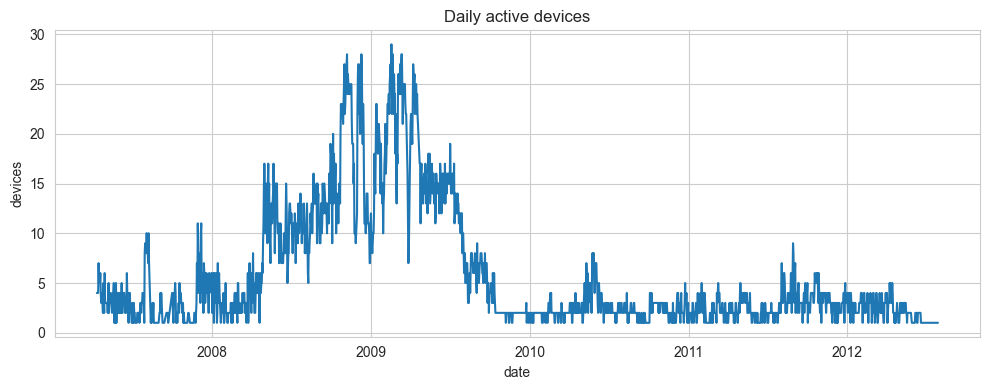

In [14]:
# Number of devices over time
# ── 1. 时间截断 ─────────────────────────────────────────
CUTOFF = pd.Timestamp("2007-04-01")      # 截断日期：含 2007-04-01 当天
df_sub = df_all[df_all["dt"] >= CUTOFF].copy()

# ── 2. 计算每日活跃设备数 ────────────────────────────────
df_sub["date"] = df_sub["dt"].dt.date

daily_devices = (df_sub.groupby("date")["user_id"]
                          .nunique()
                          .rename("devices"))

# ── 3. 绘图与保存 ───────────────────────────────────────
ax = daily_devices.plot(title="Daily active devices",
                        figsize=(10, 4))
ax.set_xlabel("date")
ax.set_ylabel("devices")
plt.tight_layout()
ax.figure.savefig("devices_over_time_post200704.png", dpi=300)

# ── 4. 基本统计量 ───────────────────────────────────────
print(daily_devices.describe())

count      2510.000000
mean       9911.145418
std       12660.247484
min           3.000000
25%        1578.250000
50%        6357.000000
75%       13448.500000
max      190495.000000
Name: pts, dtype: float64


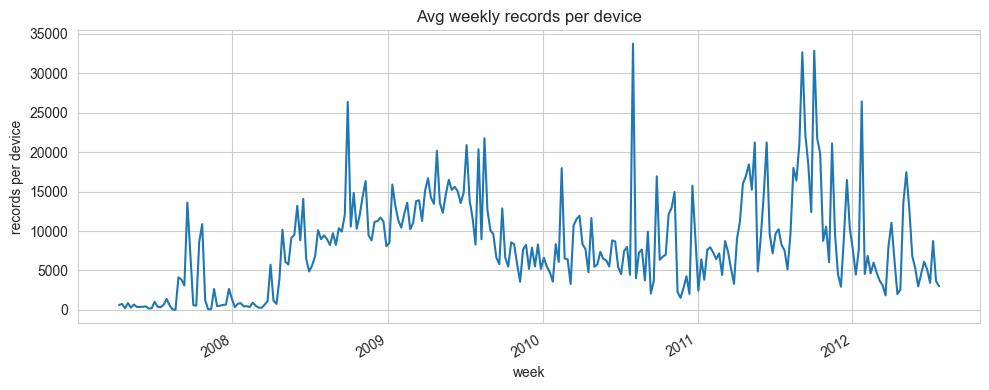

In [16]:
# Number of records per device over time
# ── 0. 预备环境 ───────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt

# df_all 需已载入，且包含 'dt' 与 'user_id' 列
# 例如：df_all = pd.concat(pd.read_feather(f) for f in CACHE.glob("*.feather"))

# ── 1. 时间截断 ─────────────────────────────────────────
CUTOFF = pd.Timestamp("2007-04-01")
df_sub = df_all[df_all["dt"] >= CUTOFF].copy()

# ── 2. 打上周粒度标签 ───────────────────────────────────
df_sub["week"] = df_sub["dt"].dt.to_period("W").dt.start_time

# ── 3. 计算每周每台设备的记录量 ─────────────────────────
week_user_counts = (df_sub.groupby(["week", "user_id"])
                            .size()
                            .rename("pts")
                            .reset_index())

# ── 4. 绘图：每周平均记录量 ──────────────────────────────
ax = (week_user_counts.groupby("week")["pts"]
      .mean()
      .plot(title="Avg weekly records per device",
            figsize=(10, 4)))
ax.set_xlabel("week")
ax.set_ylabel("records per device")
plt.tight_layout()
ax.figure.savefig("records_per_device_over_time_post200704.png", dpi=300)

# ── 5. 基本统计量 ───────────────────────────────────────
print(week_user_counts["pts"].describe())


In [17]:
# 3. Temporal Sparsity
# 3.1 Intra-day occupancy
df_all["day"]  = df_all["dt"].dt.floor("D")
df_all["hour"] = df_all["dt"].dt.hour

intra = (df_all.drop_duplicates(["user_id","day","hour"])
               .groupby(["user_id","day"])
               .size()
               .rename("active_hours")
               .reset_index())

intra["occ_ratio"] = intra["active_hours"] / 24
print(intra["occ_ratio"].describe())

count    11147.000000
mean         0.206939
std          0.147528
min          0.041667
25%          0.083333
50%          0.166667
75%          0.291667
max          1.000000
Name: occ_ratio, dtype: float64


In [18]:
# 3.2 Inter-day occupancy
user_day = df_all.drop_duplicates(["user_id","day"])
inter = (user_day.groupby("user_id")
                 .size()
                 .rename("active_days")
                 .reset_index())

total_days = (df_all["day"].max() - df_all["day"].min()).days + 1
inter["occ_ratio"] = inter["active_days"] / total_days
print(inter["occ_ratio"].describe())


count    182.000000
mean       0.013338
std        0.028917
min        0.000218
25%        0.001524
50%        0.004247
75%        0.013774
max        0.277221
Name: occ_ratio, dtype: float64


C:\Users\Nick_James\AppData\Local\Temp\ipykernel_13248\1398541681.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sub["gap_km"] = df_sub.groupby("user_id", group_keys=False).apply(calc_gap)


clean accounting
count     2.424365e+07
mean      1.888052e-02
std       6.609086e-02
min       0.000000e+00
median    9.119863e-03
p90       3.367316e-02
p95       6.510807e-02
p99       1.797495e-01
max       4.996852e+00
Name: gap_km, dtype: float64


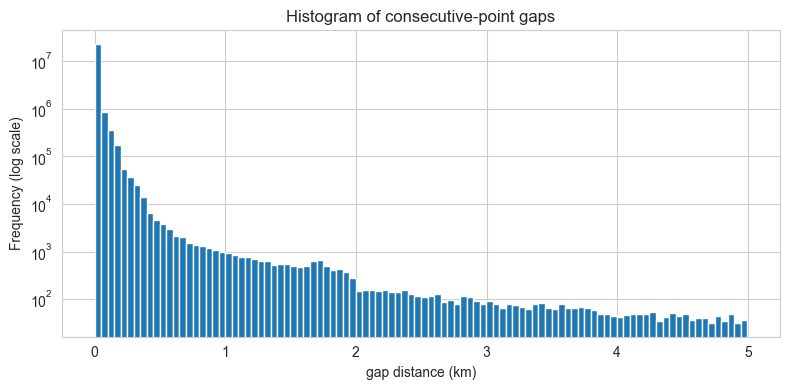

In [22]:
# 4. Spatial Sparsity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit   # pip install haversine

#  1. 时间 & 坐标过滤
CUTOFF = pd.Timestamp("2007-04-01")

df_sub = (df_all[(df_all["dt"] >= CUTOFF) &
                 (df_all["lat"].between(-90,  90)) &
                 (df_all["lon"].between(-180, 180))]
                .copy())

#  2. 计算 gap_km 及时间间隔 dt_sec
# 先按 user 排序
df_sub.sort_values(["user_id", "dt"], inplace=True)

# 计算相邻点时间差（秒）
df_sub["dt_delta"] = (df_sub.groupby("user_id")["dt"]
                              .diff()
                              .dt.total_seconds())

# 定义函数向量化计算 haversine 距离
def calc_gap(group):
    coords = group[["lat", "lon"]].to_numpy()
    if len(coords) < 2:
        return pd.Series([np.nan] * len(group), index=group.index)
    dist = np.append([np.nan],
                     [haversine(coords[i-1], coords[i], Unit.KILOMETERS)
                      for i in range(1, len(coords))])
    return pd.Series(dist, index=group.index)

df_sub["gap_km"] = df_sub.groupby("user_id", group_keys=False).apply(calc_gap)

#  3. 清洗规则
#     · 隐含速度 > 300 km/h 判为异常
#     · 或 gap_km > 5 km 亦判为异常（可根据需要调大/调小）
# 计算隐含速度 km/h
df_sub["speed_kmh"] = df_sub["gap_km"] / (df_sub["dt_delta"] / 3600)

mask_valid = (
    (df_sub["gap_km"] <= 5) &
    (df_sub["speed_kmh"].le(300) | df_sub["speed_kmh"].isna())  # 首行 NaN
)

df_clean = df_sub[mask_valid & df_sub["gap_km"].notna()].copy()

#  4. 统计结果
stats = df_clean["gap_km"].describe(
    percentiles=[.5, .9, .95, .99]).rename({
        "50%": "median",
        "90%": "p90",
        "95%": "p95",
        "99%": "p99"
    })
print("clean accounting")
print(stats)

#  5. 绘制对数直方图
plt.figure(figsize=(8, 4))
(df_clean["gap_km"]
     .plot(kind="hist", bins=100, log=True,
           title="Histogram of consecutive-point gaps"))
plt.xlabel("gap distance (km)")
plt.ylabel("Frequency (log scale)")
plt.tight_layout()
plt.savefig("spatial_gap_hist_cleaned.png", dpi=300)

df_clean.to_feather("clean_geolife_points.feather")   # 可选

In [24]:
# 5. precision
import numpy as np
import pandas as pd

# ------- 前置：确保排序 & dtype 正确 -----------------------------------------
df_all = df_all.sort_values(["user_id", "dt"]).copy()   # 不污染原表
df_all[["lat", "lon"]] = df_all[["lat", "lon"]].astype(float)

# ------- 计算前一时刻坐标 ---------------------------------------------------
df_all["lat_prev"] = df_all.groupby("user_id")["lat"].shift()
df_all["lon_prev"] = df_all.groupby("user_id")["lon"].shift()

# 只对有前一点的行计算距离
mask = df_all["lat_prev"].notna()

# ------- 矢量化 Haversine 距离（单位：米） ----------------------------------
R = 6_371_000  # 地球平均半径 (m)

phi1 = np.radians(df_all.loc[mask, "lat_prev"].values)
phi2 = np.radians(df_all.loc[mask, "lat"].values)
dphi = phi2 - phi1
dlmb = np.radians(df_all.loc[mask, "lon"].values -
                  df_all.loc[mask, "lon_prev"].values)

a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlmb / 2) ** 2
df_all.loc[mask, "dist_m"] = 2 * R * np.arcsin(np.sqrt(a))

# ------- 计算时间间隔 -------------------------------------------------------
df_all["dt_delta"] = df_all.groupby("user_id")["dt"].diff().dt.total_seconds()

# ------- 提取“静止”记录并估计定位精度 --------------------------------------
stationary = df_all[(df_all["dt_delta"] <= 60) & (df_all["dist_m"] <= 1)]

# 经纬度标准差 × 111 320 ≈ 米级 spread（经纬方向各自乘即可）
spread = (stationary.groupby("user_id")[["lat", "lon"]]
          .agg(np.std) * 111_320)

print(spread.describe())

                lat           lon
count  1.430000e+02  1.430000e+02
mean   1.527829e+05  4.876605e+05
std    2.556136e+05  1.822810e+06
min    3.417180e+00  2.168792e+01
25%    3.425495e+03  4.392032e+03
50%    1.807418e+04  1.930634e+04
75%    2.550012e+05  1.169881e+05
max    1.373899e+06  1.252709e+07


C:\Users\Nick_James\AppData\Local\Temp\ipykernel_13248\27361842.py:35: FutureWarning: The provided callable <function std at 0x000002027E429580> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  .agg(np.std) * 111_320)
